In [1]:
# TODO
# pickle model
# update P/L
# featimp chart

import warnings
import pickle
from time import strftime, localtime
import operator
from itertools import product
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import accuracy_score, f1_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

# XGBoost https://xgboost.readthedocs.io/en/latest/
# conda install -c conda-forge xgboost
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance

# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
# conda install -c conda-forge lightgbm
import lightgbm as lgb 

# Yandex CatBoost https://catboost.yandex/
# conda install -c conda-forge catboost
import catboost 
from catboost import CatBoostClassifier

random_state = 42
np.random.seed(random_state)

print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

import plotly as py
print (py.__version__) # requires version >= 1.9.0\n",
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

Start: Oct 31 2018 02:47:42
3.3.0


In [2]:
data = pd.read_pickle("complex_train.pickle")
data.head()


,TARGET,SK_ID_CURR,AMT_ANNUITY,AMT_BALANCE,AMT_CREDIT,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,VERIF_COUNT_0.0,VERIF_COUNT_0.6931471805599453,VERIF_COUNT_1.0986122886681098,VERIF_COUNT_1.3862943611198906,VERIF_COUNT_1.6094379124341003,VERIF_COUNT_1.791759469228055,VERIF_COUNT_1.9459101490553132,VERIF_COUNT_2.3978952727983707,VERIF_COUNT_3.258096538021482,VERIF_COUNT_nan
0,1,100002,24700.5,0.666223,406597.5,1.228833,0.000200,2.380193,1.213733,0.157968,...,1,0,0,0,0,0,0,0,0,0
1,0,100003,35698.5,0.666223,1293502.5,1.228833,0.000000,3.000000,0.000000,3.000000,...,1,0,0,0,0,0,0,0,0,0
2,0,100004,6750.0,0.666223,135000.0,1.228833,0.021783,7.415797,4.556346,0.169520,...,1,0,0,0,0,0,0,0,0,0
3,0,100006,29686.5,0.000000,312682.5,2.000000,0.021783,7.415797,4.556346,0.169520,...,1,0,0,0,0,0,0,0,0,0
4,0,100007,21865.5,0.666223,513000.0,1.228833,0.021783,7.415797,4.556346,0.169520,...,1,0,0,0,0,0,0,0,0,0


In [3]:
list(data.columns)

['TARGET',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_BALANCE',
 'AMT_CREDIT',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INCOME_TOTAL',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_TOTAL_RECEIVABLE',
 'APARTMENTS_AVG',
 'APPROVED_COUNT',
 'APP_COUNT',
 'BASEMENTAREA_AVG',
 'BURCOUNT',
 'BURCOUNT0',
 'BURCOUNT1',
 'BURCOUNT2',
 'BURCOUNT3',
 'BURCOUNT4',
 'BURCOUNT5',
 'BURCOUNTC',
 'BURCOUNTX',
 'BURSTAT0',
 'BURSTAT1',
 'CANCELED_COUNT',
 'CLIENT_COUNT',
 'CNT_BUREAU_REPORTS',
 'CNT_CHILDREN',
 'CNT_CREDIT_PROLONG',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_POS_C

In [4]:
# predictors : cols 2 to end
X = data.iloc[:,2:].astype(float)
#X = data.values[:,2:].astype(float)
# response: col 1
y = data["TARGET"].astype(float)


In [5]:
list(data.columns).index('AMT_REQ_CREDIT_BUREAU_DAY_0.0')

126

In [8]:
# first categorical col
first_categorical_column = 124
nrows, ncols = X.shape
data.iloc[:10,first_categorical_column+2:first_categorical_column+6]

,AMT_REQ_CREDIT_BUREAU_DAY_0.0,AMT_REQ_CREDIT_BUREAU_DAY_1.0,AMT_REQ_CREDIT_BUREAU_DAY_2.0,AMT_REQ_CREDIT_BUREAU_DAY_3.0
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,0,0,0,0


In [9]:
X.iloc[:10,first_categorical_column:first_categorical_column+4]


,AMT_REQ_CREDIT_BUREAU_DAY_0.0,AMT_REQ_CREDIT_BUREAU_DAY_1.0,AMT_REQ_CREDIT_BUREAU_DAY_2.0,AMT_REQ_CREDIT_BUREAU_DAY_3.0
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [10]:
X_train, X_xval, y_train, y_xval = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [11]:
y_train.head()

181648    0.0
229245    0.0
122525    1.0
306311    1.0
300658    0.0
Name: TARGET, dtype: float64

In [26]:
# given y_true, y_pred, find threshold that gives best f1_score
def best_f1_thresh(y_true, y_pred_proba):
    # get ROC curve thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # compute f1 at each threshold
    f1_scores = [2*p*r/(p+r) for p, r in zip(precision, recall)]
    i  = np.argmax(f1_scores)
    print("Max F1 %.3f, precision %.3f, recall %.3f" % (f1_scores[i], precision[i], recall[i]))
    return thresholds[i], i, recall[i]


In [13]:
# tune XGBoost

# values tested
max_depths = range(3,15)
subsamples = np.linspace(0.65, 0.9, 6)
colsample_by_trees = np.linspace(0.3, 0.8, 11)
learning_rates = np.logspace(-2, 0, 5)
gammas = [5]

learning_rate = 0.05
early_stopping_rounds=100

# best values found
max_depth = 8
subsample = 0.7
csbt = 0.35
gamma = 5

for gamma in gammas:

    print("#######################################################")
    print("max_depth        %d" % max_depth)
    print("learning_rate    %f" % learning_rate)
    print("subsample        %f" % subsample)
    print("colsample_bytree %f" % csbt)
    print("gamma            %d" % gamma)
    
    print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

    model = XGBClassifier(objective='binary:logistic',
                          learning_rate = learning_rate,
                          n_estimators = 30000,
                          early_stopping_rounds=early_stopping_rounds,
                          max_depth= max_depth,
                          subsample = subsample,
                          colsample_bytree = csbt,
                          gamma = gamma,
                          verbose_eval=50                          
                         )
    eval_set = [(X_xval,y_xval)]
    model.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping_rounds,
              eval_metric='auc',
              eval_set=eval_set,
             )
    # predict probability
    y_pred_xval_proba = model.predict_proba(X_xval)[:,1]
    # pick threshold for best f1
    thresh = best_f1_thresh(y_xval, y_pred_xval_proba)
    print(thresh)
    # make binary prediction
    y_pred_xval = y_pred_xval_proba >= thresh

    
    print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))
    
    print("Precision:      %.03f" % precision_score(y_xval, y_pred_xval))
    print("Recall:         %.03f" % recall_score(y_xval, y_pred_xval))
    print("F1:             %.03f" % f1_score(y_xval, y_pred_xval))
    print("Accuracy:       %.03f" % accuracy_score(y_xval, y_pred_xval))
    print("AUC:            %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))
    print("#######################################################")
    
    

#######################################################
max_depth        8
learning_rate    0.050000
subsample        0.700000
colsample_bytree 0.350000
gamma            5
Start: Oct 31 2018 02:50:05
[0]	validation_0-auc:0.668107
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.724352
[2]	validation_0-auc:0.728343
[3]	validation_0-auc:0.734366
[4]	validation_0-auc:0.740938
[5]	validation_0-auc:0.741554
[6]	validation_0-auc:0.741885
[7]	validation_0-auc:0.742117
[8]	validation_0-auc:0.742949
[9]	validation_0-auc:0.743537
[10]	validation_0-auc:0.742719
[11]	validation_0-auc:0.743653
[12]	validation_0-auc:0.745438
[13]	validation_0-auc:0.747838
[14]	validation_0-auc:0.746934
[15]	validation_0-auc:0.747723
[16]	validation_0-auc:0.747205
[17]	validation_0-auc:0.74766
[18]	validation_0-auc:0.74739
[19]	validation_0-auc:0.748869
[20]	validation_0-auc:0.748
[21]	validation_0-auc:0.748517
[22]	validation_0-auc:0.748613
[23]	validation_0-auc:0.749026
[24]	v

[253]	validation_0-auc:0.779757
[254]	validation_0-auc:0.779706
[255]	validation_0-auc:0.779738
[256]	validation_0-auc:0.779798
[257]	validation_0-auc:0.779805
[258]	validation_0-auc:0.779819
[259]	validation_0-auc:0.780039
[260]	validation_0-auc:0.7801
[261]	validation_0-auc:0.780152
[262]	validation_0-auc:0.78012
[263]	validation_0-auc:0.78007
[264]	validation_0-auc:0.78009
[265]	validation_0-auc:0.780041
[266]	validation_0-auc:0.780045
[267]	validation_0-auc:0.780115
[268]	validation_0-auc:0.780174
[269]	validation_0-auc:0.780204
[270]	validation_0-auc:0.780199
[271]	validation_0-auc:0.780168
[272]	validation_0-auc:0.780214
[273]	validation_0-auc:0.780262
[274]	validation_0-auc:0.780316
[275]	validation_0-auc:0.780372
[276]	validation_0-auc:0.780458
[277]	validation_0-auc:0.780452
[278]	validation_0-auc:0.780487
[279]	validation_0-auc:0.780502
[280]	validation_0-auc:0.780556
[281]	validation_0-auc:0.780558
[282]	validation_0-auc:0.78054
[283]	validation_0-auc:0.780593
[284]	validati

[510]	validation_0-auc:0.782227
[511]	validation_0-auc:0.782256
[512]	validation_0-auc:0.782275
[513]	validation_0-auc:0.782293
[514]	validation_0-auc:0.782338
[515]	validation_0-auc:0.782375
[516]	validation_0-auc:0.78238
[517]	validation_0-auc:0.782375
[518]	validation_0-auc:0.782367
[519]	validation_0-auc:0.782353
[520]	validation_0-auc:0.782333
[521]	validation_0-auc:0.782293
[522]	validation_0-auc:0.782295
[523]	validation_0-auc:0.782272
[524]	validation_0-auc:0.782266
[525]	validation_0-auc:0.782312
[526]	validation_0-auc:0.782308
[527]	validation_0-auc:0.782332
[528]	validation_0-auc:0.782273
[529]	validation_0-auc:0.782296
[530]	validation_0-auc:0.782312
[531]	validation_0-auc:0.782322
[532]	validation_0-auc:0.782329
[533]	validation_0-auc:0.782277
[534]	validation_0-auc:0.782307
[535]	validation_0-auc:0.782343
[536]	validation_0-auc:0.782351
[537]	validation_0-auc:0.782351
[538]	validation_0-auc:0.782333
[539]	validation_0-auc:0.782302
[540]	validation_0-auc:0.782313
[541]	val

In [14]:
joblib.dump(model, 'finalmodel.joblib')

['finalmodel.joblib']

In [20]:
def profit_at_thresh(y_true, y_pred_proba, l_ratio, thresh):
        y_candidate = y_pred_proba > thresh
        true_negs = sum((y_candidate == 0) &( y_true==0))
        false_negs = sum((y_candidate == 0) &( y_true==1))
        profit = true_negs - false_negs * l_ratio
        return profit

def best_profit_thresh(y_true, y_pred_proba, l_ratio):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plist = []
    print("testing %d thresholds" % len(thresholds))
    for j, thresh in enumerate(thresholds):
        if j % 1000 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()
        y_candidate = y_pred_proba > thresh
        true_negs = sum((y_candidate == 0) &( y_true==0))
        false_negs = sum((y_candidate == 0) &( y_true==1))
        profit = true_negs - false_negs * l_ratio
        #print(j, thresh, true_negs, false_negs, profit)
        plist.append(profit_at_thresh(y_true, y_pred_proba, l_ratio, thresh))
    i = np.argmax(plist)
    thresh = thresholds[i]
    y_candidate = y_pred_proba > thresh
    true_negs = sum((y_candidate == 0) & ( y_true==0))
    false_negs = sum((y_candidate == 0) &( y_true==1))
    print("\nThreshold to maximize value: %f" % thresholds[i])
    print("Performant: %d Nonperformant %d" % (true_negs, false_negs))
    print("FPR %f TPR %f" % (fpr[i], tpr[i]))
    print("Value: %f" % plist[i])
    return thresholds[i], plist[i], tpr[i]



In [27]:
# predict probability, accuracy, value
y_pred_xval_proba = model.predict_proba(X_xval)[:,1]
# pick threshold for best f1
thresh1, threshindex1, threshrecall1 = best_f1_thresh(y_xval, y_pred_xval_proba)
# make binary prediction
y_pred_xval = y_pred_xval_proba >= thresh1

l1_ratio = 11.387311178247733

print("Accuracy: %.03f" % accuracy_score(y_xval, y_pred_xval))
print("F1 %.03f" % f1_score(y_xval, y_pred_xval))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))
print(confusion_matrix(y_xval, y_pred_xval))
print("profit at max F1: %.02f" % profit_at_thresh(y_xval, y_pred_xval_proba, l1_ratio, thresh1))


Max F1 0.343, precision 0.296, recall 0.408
Accuracy: 0.874
F1 0.343
AUC 0.782
[[51723  4815]
 [ 2940  2025]]
profit at max F1: 18232.92


In [30]:
print("max profit analysis:")
profit_thresh1, profit1, profitrecall1 =best_profit_thresh(y_xval, y_pred_xval_proba, l1_ratio)
print("Max profit %.02f, threshold %.08f" % (profit1,profit_thresh1))

max profit analysis:
testing 8313 thresholds
.........
Threshold to maximize value: 0.069093
Performant: 38345 Nonperformant 1260
FPR 0.321801 TPR 0.746224
Value: 23996.987915
Max profit 23996.99, threshold 0.06909276


In [31]:
y_pred_xval2 = y_pred_xval_proba >= profit_thresh1
print("Accuracy: %.03f" % accuracy_score(y_xval, y_pred_xval2))
print("F1 %.03f" % f1_score(y_xval, y_pred_xval2))
print("AUC %.03f" % roc_auc_score(y_score=y_pred_xval_proba,y_true=y_xval))
print(confusion_matrix(y_xval, y_pred_xval2))

Accuracy: 0.684
F1 0.276
AUC 0.782
[[38344 18194]
 [ 1260  3705]]


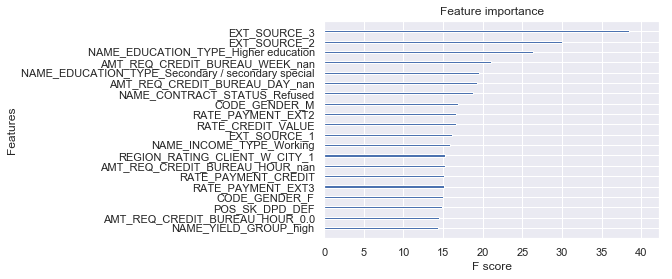

In [24]:
plot_importance(model,importance_type='gain', show_values=False, max_num_features=20);


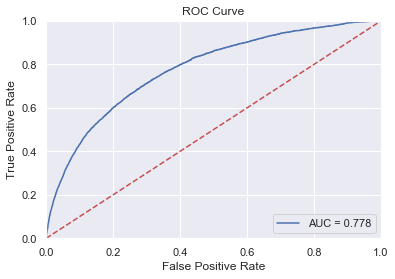

In [16]:
def plot_roc_curve(y_xval, y_pred):
    fpr, tpr, threshold = roc_curve(y_xval, y_pred)
    roc_auc = auc(fpr, tpr)


    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();
    
plot_roc_curve(y_xval, y_pred_xval_proba)

In [33]:
def plotly_roc_curve(y_xval, y_pred_xval_proba, recall_values=None, recall_labels=None):
    
    fpr, tpr, threshold = roc_curve(y_xval, y_pred_xval_proba)
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    
    traces = []
    traces.append(Scatter(x=fpr, y=tpr, 
                          mode='lines', 
                          line=dict(color='darkorange', width=lw),
                          name='ROC curve (area = %0.3f)' % roc_auc
                         )
                 )

    traces.append(Scatter(x=[0, 1], y=[0, 1], 
                          mode='lines', 
                          line=dict(color='navy', width=lw, dash='dash'),
                          showlegend=False)
                 )

    if recall_labels:
        # look up closest index in tpr
        for i, recall_label in enumerate(recall_labels):
            recall_value = recall_values[i]
            best_f1_index = np.abs(tpr - recall_value).argmin()
            traces.append(Scatter(x=[fpr[best_f1_index]], 
                                  y=[tpr[best_f1_index]], 
                                  text=recall_label,
                                  mode='markers+text', 
                                  textposition='top left',  
                                  marker = dict(
                                      size = 10,
                                      color = 'rgba(152, 0, 0, .8)',
                                      line = dict(
                                          width = 2,
                                          color = 'rgb(0, 0, 0)'
                                      )
                                  ),
                                  showlegend=False)
                         )
            
    layout = Layout(title='ROC Curve - Complex Model',
                    legend=dict(x=0.75, y=0.05),
                    xaxis=dict(title='False Positive Rate',
                               linecolor='black',
                               linewidth=1,
                               mirror=True,
                               range=[0, 1]                               
                              ),
                    yaxis=dict(title='True Positive Rate',
                               linecolor='black',
                               linewidth=1,
                               mirror=True,
                               range=[0, 1]                               
                              )
                   )
    fig = Figure(data=traces, layout=layout)
    return iplot(fig)

fpr1, tpr1, threshold1 = roc_curve(y_xval, y_pred_xval_proba)
roc_auc1 = auc(fpr1, tpr1)

plotly_roc_curve(y_xval, y_pred_xval_proba, recall_values=[threshrecall1, profitrecall1], recall_labels=["Max F1", "Max Profit"])

In [34]:
featimpdict = model._Booster.get_score(importance_type='gain')

xgb_featlabels=[]
xgb_featimps = []

for key, val in reversed(sorted(featimpdict.items(), key=operator.itemgetter(1))):
    xgb_featlabels.append(key)
    xgb_featimps.append(val)

def plotly_feat_imp(labels, featimps, name):

    trace1 = Bar(
        x=labels[:30],
        y=featimps[:30],
        name=name,
    )

    zlayout = Layout(
        title='%s Feature Importance' % (name),        
        xaxis = dict(title = "", 
                     tickangle=30,
                     tickfont=dict(
                         size=10,
                         color='black'
                     )),
        yaxis = dict(title = "Importance", 
                    ),
        
        margin=layout.Margin(
            b=150,
        ),    
        barmode='group',
    )

    data = [trace1]
    
    fig = Figure(data=data, layout=zlayout)
    iplot(fig)

plotly_feat_imp(xgb_featlabels, xgb_featimps, "XGBoost")


In [74]:
# retrain with these hyperparams on all of X
# no xval set, no early stopping
# learning rate 0.05, 600 rounds

max_depth = 8
subsample = 0.7
csbt = 0.35
learning_rate = 0.05
gamma = 5

# use thresh found previously in xval
thresh = 0.15066245

print("#######################################################")
print("max_depth        %d" % max_depth)
print("learning_rate    %f" % learning_rate)
print("subsample        %f" % subsample)
print("colsample_bytree %f" % csbt)
print("gamma            %d" % gamma)
    
print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

model = XGBClassifier(objective='binary:logistic',
                      learning_rate = learning_rate,
                      n_estimators = 600,
                      max_depth= max_depth,
                      subsample = subsample,
                      colsample_bytree = csbt,
                      gamma = gamma,
#                      verbose_eval=50                      
                     )

model.fit(X, y)
# predict probability in X
y_pred_train_proba = model.predict_proba(X)[:,1]
# make binary prediction
y_pred_train = y_pred_train_proba >= thresh

print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

#######################################################
max_depth        8
learning_rate    0.050000
subsample        0.700000
colsample_bytree 0.350000
gamma            5
Start: Oct 30 2018 18:19:31


KeyboardInterrupt: 

In [26]:
print("Training Precision:      %.03f" % precision_score(y, y_pred_train))
print("Training Recall:         %.03f" % recall_score(y, y_pred_train))
print("Training F1:             %.03f" % f1_score(y, y_pred_train))
print("Training Accuracy:       %.03f" % accuracy_score(y, y_pred_train))
print("Training AUC:            %.03f" % roc_auc_score(y_score=y_pred_train_proba,y_true=y))
print("#######################################################")

Training Precision:      0.358
Training Recall:         0.605
Training F1:             0.449
Training Accuracy:       0.880
Training AUC:            0.870
#######################################################


In [27]:
with open('model_complex.pickle', 'wb') as file:
    pickle.dump(model, file)


In [28]:
from time import strftime, localtime
print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))


End: Oct 29 2018 12:53:35


In [19]:
test_df = pd.read_pickle("complex_test.pickle")
test_df.head()


,SK_ID_CURR,AMT_ANNUITY,AMT_BALANCE,AMT_CREDIT,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,...,VERIF_COUNT_0.0,VERIF_COUNT_0.6931471805599453,VERIF_COUNT_1.0986122886681098,VERIF_COUNT_1.3862943611198906,VERIF_COUNT_1.6094379124341003,VERIF_COUNT_1.791759469228055,VERIF_COUNT_1.9459101490553132,VERIF_COUNT_2.3978952727983707,VERIF_COUNT_3.258096538021482,VERIF_COUNT_nan
307511,100001,20560.5,0.666223,568800.0,1.228833,0.021783,6.548333,4.419896,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
307512,100005,17370.0,0.666223,222768.0,1.228833,0.000000,6.046727,5.741495,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
307513,100013,69777.0,0.000000,663264.0,0.222222,0.021783,7.415797,4.556346,0.169520,0.001658,...,1,0,0,0,0,0,0,0,0,0
307514,100028,49018.5,0.118527,1575000.0,0.714286,0.000000,2.745146,0.591441,0.321876,0.000000,...,1,0,0,0,0,0,0,0,0,0
307515,100038,32067.0,0.666223,625500.0,1.228833,0.021783,7.415797,4.556346,0.169520,0.001658,...,1,0,0,0,0,0,0,0,0,0


In [20]:
# predictors : cols 2 to end
X_test = test_df.iloc[:,1:].astype(float)
#X = data.values[:,2:].astype(float)
# response: col 1



In [65]:
max_depth = 8
subsample = 0.7
csbt = 0.35
gamma = 5

#early_stopping_rounds=10
early_stopping_rounds=100
#learning_rate = 0.1
learning_rate = 0.01

#######################################################
# KFOLD CV WITH EARLY STOPPING, AVG FOR SUBMISSION
#######################################################

print("Start: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))

K = 5
kf = KFold(n_splits = K, random_state = random_state, shuffle = True)
xgb_preds = []
for train_index, test_index in kf.split(X):
    
    X_train, X_xval = X.iloc[train_index], X.iloc[test_index]
    y_train, y_xval = y.iloc[train_index], y.iloc[test_index]

    model = XGBClassifier(objective='binary:logistic',
                          learning_rate = learning_rate,
                          n_estimators = 30000,
                          early_stopping_rounds=early_stopping_rounds,
                          max_depth= max_depth,
                          subsample = subsample,
                          colsample_bytree = csbt,
                          gamma = gamma,
                          verbose_eval=50                      
                     )

    eval_set = [(X_xval,y_xval)]
    
    model.fit(X_train, y_train, 
              early_stopping_rounds=early_stopping_rounds,
              eval_metric='auc',
              eval_set=eval_set,
             )

    xgb_pred = model.predict_proba(data=X_test)[:,1]
    xgb_preds.append(list(xgb_pred))
    
print("End: %s" % strftime("%b %d %Y %H:%M:%S", localtime()))


Start: Oct 30 2018 01:03:44
[0]	validation_0-auc:0.660597
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.71861
[2]	validation_0-auc:0.725305
[3]	validation_0-auc:0.73178
[4]	validation_0-auc:0.740205
[5]	validation_0-auc:0.740177
[6]	validation_0-auc:0.740039
[7]	validation_0-auc:0.740505
[8]	validation_0-auc:0.741628
[9]	validation_0-auc:0.741361
[10]	validation_0-auc:0.740715
[11]	validation_0-auc:0.742292
[12]	validation_0-auc:0.743587
[13]	validation_0-auc:0.745802
[14]	validation_0-auc:0.744952
[15]	validation_0-auc:0.745578
[16]	validation_0-auc:0.745261
[17]	validation_0-auc:0.745361
[18]	validation_0-auc:0.744588
[19]	validation_0-auc:0.746102
[20]	validation_0-auc:0.745903
[21]	validation_0-auc:0.745846
[22]	validation_0-auc:0.745326
[23]	validation_0-auc:0.745477
[24]	validation_0-auc:0.745204
[25]	validation_0-auc:0.745464
[26]	validation_0-auc:0.745283
[27]	validation_0-auc:0.744991
[28]	validation_0-auc:0.745205
[29]	validation_0-au

[285]	validation_0-auc:0.761315
[286]	validation_0-auc:0.761375
[287]	validation_0-auc:0.761384
[288]	validation_0-auc:0.761512
[289]	validation_0-auc:0.761613
[290]	validation_0-auc:0.761637
[291]	validation_0-auc:0.761661
[292]	validation_0-auc:0.761782
[293]	validation_0-auc:0.761822
[294]	validation_0-auc:0.761959
[295]	validation_0-auc:0.762015
[296]	validation_0-auc:0.762115
[297]	validation_0-auc:0.762187
[298]	validation_0-auc:0.762221
[299]	validation_0-auc:0.762233
[300]	validation_0-auc:0.762238
[301]	validation_0-auc:0.762282
[302]	validation_0-auc:0.762324
[303]	validation_0-auc:0.762344
[304]	validation_0-auc:0.762455
[305]	validation_0-auc:0.762514
[306]	validation_0-auc:0.762622
[307]	validation_0-auc:0.76265
[308]	validation_0-auc:0.762683
[309]	validation_0-auc:0.762697
[310]	validation_0-auc:0.762718
[311]	validation_0-auc:0.762771
[312]	validation_0-auc:0.762771
[313]	validation_0-auc:0.762837
[314]	validation_0-auc:0.762838
[315]	validation_0-auc:0.762841
[316]	val

[542]	validation_0-auc:0.772865
[543]	validation_0-auc:0.77287
[544]	validation_0-auc:0.772883
[545]	validation_0-auc:0.772931
[546]	validation_0-auc:0.772955
[547]	validation_0-auc:0.773001
[548]	validation_0-auc:0.773002
[549]	validation_0-auc:0.773008
[550]	validation_0-auc:0.773028
[551]	validation_0-auc:0.773025
[552]	validation_0-auc:0.773098
[553]	validation_0-auc:0.773148
[554]	validation_0-auc:0.773127
[555]	validation_0-auc:0.773176
[556]	validation_0-auc:0.773183
[557]	validation_0-auc:0.773225
[558]	validation_0-auc:0.773252
[559]	validation_0-auc:0.773274
[560]	validation_0-auc:0.773332
[561]	validation_0-auc:0.773419
[562]	validation_0-auc:0.77346
[563]	validation_0-auc:0.773524
[564]	validation_0-auc:0.773544
[565]	validation_0-auc:0.773564
[566]	validation_0-auc:0.773605
[567]	validation_0-auc:0.773602
[568]	validation_0-auc:0.773604
[569]	validation_0-auc:0.773624
[570]	validation_0-auc:0.773626
[571]	validation_0-auc:0.773628
[572]	validation_0-auc:0.773645
[573]	vali

[800]	validation_0-auc:0.778093
[801]	validation_0-auc:0.778103
[802]	validation_0-auc:0.778109
[803]	validation_0-auc:0.778114
[804]	validation_0-auc:0.778135
[805]	validation_0-auc:0.778137
[806]	validation_0-auc:0.778153
[807]	validation_0-auc:0.778186
[808]	validation_0-auc:0.778193
[809]	validation_0-auc:0.77821
[810]	validation_0-auc:0.778233
[811]	validation_0-auc:0.778234
[812]	validation_0-auc:0.778269
[813]	validation_0-auc:0.778264
[814]	validation_0-auc:0.77829
[815]	validation_0-auc:0.77827
[816]	validation_0-auc:0.778274
[817]	validation_0-auc:0.778273
[818]	validation_0-auc:0.77832
[819]	validation_0-auc:0.778326
[820]	validation_0-auc:0.778345
[821]	validation_0-auc:0.778358
[822]	validation_0-auc:0.778367
[823]	validation_0-auc:0.778382
[824]	validation_0-auc:0.778397
[825]	validation_0-auc:0.778407
[826]	validation_0-auc:0.778422
[827]	validation_0-auc:0.778429
[828]	validation_0-auc:0.778436
[829]	validation_0-auc:0.778448
[830]	validation_0-auc:0.778458
[831]	valida

[1056]	validation_0-auc:0.780728
[1057]	validation_0-auc:0.780728
[1058]	validation_0-auc:0.780747
[1059]	validation_0-auc:0.780761
[1060]	validation_0-auc:0.780787
[1061]	validation_0-auc:0.78079
[1062]	validation_0-auc:0.780802
[1063]	validation_0-auc:0.780826
[1064]	validation_0-auc:0.780832
[1065]	validation_0-auc:0.780834
[1066]	validation_0-auc:0.780836
[1067]	validation_0-auc:0.780846
[1068]	validation_0-auc:0.780843
[1069]	validation_0-auc:0.780856
[1070]	validation_0-auc:0.780863
[1071]	validation_0-auc:0.780876
[1072]	validation_0-auc:0.780882
[1073]	validation_0-auc:0.780881
[1074]	validation_0-auc:0.7809
[1075]	validation_0-auc:0.780888
[1076]	validation_0-auc:0.780879
[1077]	validation_0-auc:0.780888
[1078]	validation_0-auc:0.780905
[1079]	validation_0-auc:0.780923
[1080]	validation_0-auc:0.780945
[1081]	validation_0-auc:0.780963
[1082]	validation_0-auc:0.780969
[1083]	validation_0-auc:0.78099
[1084]	validation_0-auc:0.781001
[1085]	validation_0-auc:0.781007
[1086]	validat

[1305]	validation_0-auc:0.782212
[1306]	validation_0-auc:0.782217
[1307]	validation_0-auc:0.782212
[1308]	validation_0-auc:0.782224
[1309]	validation_0-auc:0.782237
[1310]	validation_0-auc:0.782245
[1311]	validation_0-auc:0.782245
[1312]	validation_0-auc:0.782243
[1313]	validation_0-auc:0.782246
[1314]	validation_0-auc:0.782245
[1315]	validation_0-auc:0.782242
[1316]	validation_0-auc:0.782266
[1317]	validation_0-auc:0.782307
[1318]	validation_0-auc:0.78231
[1319]	validation_0-auc:0.782312
[1320]	validation_0-auc:0.782319
[1321]	validation_0-auc:0.78231
[1322]	validation_0-auc:0.782303
[1323]	validation_0-auc:0.782309
[1324]	validation_0-auc:0.782326
[1325]	validation_0-auc:0.782321
[1326]	validation_0-auc:0.782324
[1327]	validation_0-auc:0.782332
[1328]	validation_0-auc:0.782321
[1329]	validation_0-auc:0.782325
[1330]	validation_0-auc:0.782329
[1331]	validation_0-auc:0.782328
[1332]	validation_0-auc:0.782331
[1333]	validation_0-auc:0.782333
[1334]	validation_0-auc:0.78234
[1335]	valida

[1554]	validation_0-auc:0.783349
[1555]	validation_0-auc:0.783354
[1556]	validation_0-auc:0.783359
[1557]	validation_0-auc:0.783365
[1558]	validation_0-auc:0.783373
[1559]	validation_0-auc:0.783379
[1560]	validation_0-auc:0.783378
[1561]	validation_0-auc:0.783403
[1562]	validation_0-auc:0.783411
[1563]	validation_0-auc:0.783413
[1564]	validation_0-auc:0.783412
[1565]	validation_0-auc:0.783412
[1566]	validation_0-auc:0.783427
[1567]	validation_0-auc:0.783422
[1568]	validation_0-auc:0.783411
[1569]	validation_0-auc:0.783423
[1570]	validation_0-auc:0.783421
[1571]	validation_0-auc:0.783415
[1572]	validation_0-auc:0.78342
[1573]	validation_0-auc:0.783435
[1574]	validation_0-auc:0.783455
[1575]	validation_0-auc:0.783449
[1576]	validation_0-auc:0.783443
[1577]	validation_0-auc:0.783452
[1578]	validation_0-auc:0.78346
[1579]	validation_0-auc:0.783464
[1580]	validation_0-auc:0.783471
[1581]	validation_0-auc:0.783476
[1582]	validation_0-auc:0.783477
[1583]	validation_0-auc:0.783477
[1584]	valid

[1804]	validation_0-auc:0.784084
[1805]	validation_0-auc:0.784076
[1806]	validation_0-auc:0.784073
[1807]	validation_0-auc:0.784078
[1808]	validation_0-auc:0.784073
[1809]	validation_0-auc:0.784072
[1810]	validation_0-auc:0.784073
[1811]	validation_0-auc:0.784078
[1812]	validation_0-auc:0.784082
[1813]	validation_0-auc:0.784088
[1814]	validation_0-auc:0.784085
[1815]	validation_0-auc:0.784089
[1816]	validation_0-auc:0.784079
[1817]	validation_0-auc:0.784075
[1818]	validation_0-auc:0.784079
[1819]	validation_0-auc:0.784086
[1820]	validation_0-auc:0.784098
[1821]	validation_0-auc:0.78409
[1822]	validation_0-auc:0.78409
[1823]	validation_0-auc:0.784098
[1824]	validation_0-auc:0.784112
[1825]	validation_0-auc:0.784127
[1826]	validation_0-auc:0.784127
[1827]	validation_0-auc:0.784127
[1828]	validation_0-auc:0.784157
[1829]	validation_0-auc:0.784162
[1830]	validation_0-auc:0.784165
[1831]	validation_0-auc:0.784165
[1832]	validation_0-auc:0.784171
[1833]	validation_0-auc:0.784168
[1834]	valid

[2054]	validation_0-auc:0.784622
[2055]	validation_0-auc:0.784616
[2056]	validation_0-auc:0.784613
[2057]	validation_0-auc:0.784616
[2058]	validation_0-auc:0.784616
[2059]	validation_0-auc:0.784616
[2060]	validation_0-auc:0.784615
[2061]	validation_0-auc:0.784615
[2062]	validation_0-auc:0.784614
[2063]	validation_0-auc:0.78461
[2064]	validation_0-auc:0.784611
[2065]	validation_0-auc:0.784604
[2066]	validation_0-auc:0.784604
[2067]	validation_0-auc:0.784605
[2068]	validation_0-auc:0.784596
[2069]	validation_0-auc:0.784616
[2070]	validation_0-auc:0.784627
[2071]	validation_0-auc:0.784621
[2072]	validation_0-auc:0.78462
[2073]	validation_0-auc:0.784622
[2074]	validation_0-auc:0.78463
[2075]	validation_0-auc:0.784635
[2076]	validation_0-auc:0.784641
[2077]	validation_0-auc:0.784649
[2078]	validation_0-auc:0.78465
[2079]	validation_0-auc:0.784652
[2080]	validation_0-auc:0.784651
[2081]	validation_0-auc:0.784637
[2082]	validation_0-auc:0.784638
[2083]	validation_0-auc:0.784635
[2084]	validat

[2330]	validation_0-auc:0.784953
[2331]	validation_0-auc:0.784958
[2332]	validation_0-auc:0.784957
[2333]	validation_0-auc:0.784965
[2334]	validation_0-auc:0.784968
[2335]	validation_0-auc:0.784969
[2336]	validation_0-auc:0.78497
[2337]	validation_0-auc:0.784956
[2338]	validation_0-auc:0.784961
[2339]	validation_0-auc:0.784948
[2340]	validation_0-auc:0.784958
[2341]	validation_0-auc:0.784959
[2342]	validation_0-auc:0.784957
[2343]	validation_0-auc:0.784956
[2344]	validation_0-auc:0.78496
[2345]	validation_0-auc:0.784964
[2346]	validation_0-auc:0.784967
[2347]	validation_0-auc:0.784972
[2348]	validation_0-auc:0.784978
[2349]	validation_0-auc:0.784974
[2350]	validation_0-auc:0.78497
[2351]	validation_0-auc:0.784971
[2352]	validation_0-auc:0.784967
[2353]	validation_0-auc:0.78497
[2354]	validation_0-auc:0.784962
[2355]	validation_0-auc:0.784962
[2356]	validation_0-auc:0.784967
[2357]	validation_0-auc:0.784971
[2358]	validation_0-auc:0.784976
[2359]	validation_0-auc:0.784971
[2360]	validat

[2580]	validation_0-auc:0.785202
[2581]	validation_0-auc:0.785212
[2582]	validation_0-auc:0.785212
[2583]	validation_0-auc:0.785212
[2584]	validation_0-auc:0.785219
[2585]	validation_0-auc:0.785226
[2586]	validation_0-auc:0.785229
[2587]	validation_0-auc:0.785233
[2588]	validation_0-auc:0.785236
[2589]	validation_0-auc:0.78524
[2590]	validation_0-auc:0.78524
[2591]	validation_0-auc:0.785237
[2592]	validation_0-auc:0.785238
[2593]	validation_0-auc:0.785231
[2594]	validation_0-auc:0.785228
[2595]	validation_0-auc:0.78523
[2596]	validation_0-auc:0.785228
[2597]	validation_0-auc:0.785226
[2598]	validation_0-auc:0.785234
[2629]	validation_0-auc:0.785254
[2630]	validation_0-auc:0.785259
[2631]	validation_0-auc:0.785261
[2632]	validation_0-auc:0.785268
[2633]	validation_0-auc:0.785263
[2634]	validation_0-auc:0.785265
[2635]	validation_0-auc:0.785272
[2636]	validation_0-auc:0.785275
[2637]	validation_0-auc:0.785276
[2638]	validation_0-auc:0.785272
[2639]	validation_0-auc:0.785289
[2640]	valida

[2860]	validation_0-auc:0.78546
[2861]	validation_0-auc:0.785459
[2862]	validation_0-auc:0.785455
[2863]	validation_0-auc:0.785455
[2864]	validation_0-auc:0.78545
[2865]	validation_0-auc:0.785447
[2866]	validation_0-auc:0.785465
[2867]	validation_0-auc:0.785465
[2868]	validation_0-auc:0.785462
[2869]	validation_0-auc:0.785464
[2870]	validation_0-auc:0.785461
[2871]	validation_0-auc:0.785453
[2872]	validation_0-auc:0.785448
[2873]	validation_0-auc:0.785449
[2874]	validation_0-auc:0.78545
[2875]	validation_0-auc:0.785448
[2876]	validation_0-auc:0.785444
[2877]	validation_0-auc:0.785441
[2878]	validation_0-auc:0.785438
[2879]	validation_0-auc:0.785432
[2880]	validation_0-auc:0.78542
[2881]	validation_0-auc:0.785415
[2882]	validation_0-auc:0.785413
[2883]	validation_0-auc:0.785422
[2884]	validation_0-auc:0.785425
[2885]	validation_0-auc:0.785429
[2886]	validation_0-auc:0.785429
[2887]	validation_0-auc:0.785423
[2888]	validation_0-auc:0.785428
[2889]	validation_0-auc:0.785426
[2890]	validat

[147]	validation_0-auc:0.752119
[148]	validation_0-auc:0.752137
[149]	validation_0-auc:0.75222
[150]	validation_0-auc:0.752403
[151]	validation_0-auc:0.752371
[152]	validation_0-auc:0.752506
[153]	validation_0-auc:0.752545
[154]	validation_0-auc:0.752675
[155]	validation_0-auc:0.752643
[156]	validation_0-auc:0.752637
[157]	validation_0-auc:0.752656
[158]	validation_0-auc:0.752621
[159]	validation_0-auc:0.752653
[160]	validation_0-auc:0.752723
[161]	validation_0-auc:0.752736
[162]	validation_0-auc:0.752805
[163]	validation_0-auc:0.752977
[164]	validation_0-auc:0.752999
[165]	validation_0-auc:0.753074
[166]	validation_0-auc:0.753043
[167]	validation_0-auc:0.752987
[168]	validation_0-auc:0.752966
[169]	validation_0-auc:0.753126
[170]	validation_0-auc:0.753105
[171]	validation_0-auc:0.753327
[172]	validation_0-auc:0.753393
[173]	validation_0-auc:0.753461
[174]	validation_0-auc:0.75349
[175]	validation_0-auc:0.75352
[176]	validation_0-auc:0.753665
[177]	validation_0-auc:0.753774
[178]	valid

[404]	validation_0-auc:0.766214
[405]	validation_0-auc:0.766308
[406]	validation_0-auc:0.766338
[407]	validation_0-auc:0.76638
[408]	validation_0-auc:0.766458
[409]	validation_0-auc:0.766487
[410]	validation_0-auc:0.766501
[411]	validation_0-auc:0.766551
[412]	validation_0-auc:0.766616
[413]	validation_0-auc:0.766667
[414]	validation_0-auc:0.766664
[415]	validation_0-auc:0.766694
[416]	validation_0-auc:0.766785
[417]	validation_0-auc:0.766841
[418]	validation_0-auc:0.766927
[419]	validation_0-auc:0.76694
[420]	validation_0-auc:0.766967
[421]	validation_0-auc:0.767007
[422]	validation_0-auc:0.767066
[423]	validation_0-auc:0.767117
[424]	validation_0-auc:0.767162
[425]	validation_0-auc:0.767229
[426]	validation_0-auc:0.767266
[427]	validation_0-auc:0.767349
[428]	validation_0-auc:0.767379
[429]	validation_0-auc:0.767419
[430]	validation_0-auc:0.767494
[431]	validation_0-auc:0.767528
[432]	validation_0-auc:0.76759
[433]	validation_0-auc:0.767687
[434]	validation_0-auc:0.767735
[435]	valid

[661]	validation_0-auc:0.77467
[662]	validation_0-auc:0.774706
[663]	validation_0-auc:0.774718
[664]	validation_0-auc:0.774751
[665]	validation_0-auc:0.774801
[666]	validation_0-auc:0.774823
[667]	validation_0-auc:0.774837
[668]	validation_0-auc:0.774836
[669]	validation_0-auc:0.774847
[670]	validation_0-auc:0.774862
[671]	validation_0-auc:0.774862
[672]	validation_0-auc:0.774863
[673]	validation_0-auc:0.774869
[674]	validation_0-auc:0.774896
[675]	validation_0-auc:0.774903
[676]	validation_0-auc:0.774926
[677]	validation_0-auc:0.774927
[678]	validation_0-auc:0.774948
[679]	validation_0-auc:0.77498
[680]	validation_0-auc:0.77498
[681]	validation_0-auc:0.775004
[682]	validation_0-auc:0.77502
[683]	validation_0-auc:0.775047
[684]	validation_0-auc:0.775065
[685]	validation_0-auc:0.775092
[686]	validation_0-auc:0.775106
[687]	validation_0-auc:0.775158
[688]	validation_0-auc:0.775193
[689]	validation_0-auc:0.775191
[690]	validation_0-auc:0.775219
[691]	validation_0-auc:0.775235
[692]	valida

[919]	validation_0-auc:0.778412
[920]	validation_0-auc:0.778417
[921]	validation_0-auc:0.778411
[922]	validation_0-auc:0.778437
[923]	validation_0-auc:0.778438
[924]	validation_0-auc:0.778439
[925]	validation_0-auc:0.778434
[926]	validation_0-auc:0.778441
[927]	validation_0-auc:0.778446
[928]	validation_0-auc:0.778454
[929]	validation_0-auc:0.778468
[930]	validation_0-auc:0.778474
[931]	validation_0-auc:0.778484
[932]	validation_0-auc:0.778504
[933]	validation_0-auc:0.778518
[934]	validation_0-auc:0.778527
[935]	validation_0-auc:0.778521
[936]	validation_0-auc:0.778525
[937]	validation_0-auc:0.778528
[938]	validation_0-auc:0.778527
[939]	validation_0-auc:0.778541
[940]	validation_0-auc:0.778545
[941]	validation_0-auc:0.778553
[942]	validation_0-auc:0.778552
[943]	validation_0-auc:0.778575
[944]	validation_0-auc:0.778571
[945]	validation_0-auc:0.778565
[946]	validation_0-auc:0.778564
[947]	validation_0-auc:0.778587
[948]	validation_0-auc:0.778595
[949]	validation_0-auc:0.778597
[950]	va

[1171]	validation_0-auc:0.780196
[1172]	validation_0-auc:0.780209
[1173]	validation_0-auc:0.780205
[1174]	validation_0-auc:0.780206
[1175]	validation_0-auc:0.780211
[1176]	validation_0-auc:0.780217
[1177]	validation_0-auc:0.780226
[1178]	validation_0-auc:0.780246
[1179]	validation_0-auc:0.780258
[1180]	validation_0-auc:0.780263
[1181]	validation_0-auc:0.78027
[1182]	validation_0-auc:0.780265
[1183]	validation_0-auc:0.78027
[1184]	validation_0-auc:0.780287
[1185]	validation_0-auc:0.780285
[1186]	validation_0-auc:0.780294
[1187]	validation_0-auc:0.78029
[1188]	validation_0-auc:0.780289
[1189]	validation_0-auc:0.780301
[1190]	validation_0-auc:0.780305
[1191]	validation_0-auc:0.780305
[1192]	validation_0-auc:0.780306
[1193]	validation_0-auc:0.780309
[1194]	validation_0-auc:0.780309
[1195]	validation_0-auc:0.780331
[1196]	validation_0-auc:0.780345
[1197]	validation_0-auc:0.780356
[1198]	validation_0-auc:0.780365
[1199]	validation_0-auc:0.780361
[1200]	validation_0-auc:0.780362
[1201]	valida

[1420]	validation_0-auc:0.781355
[1421]	validation_0-auc:0.781358
[1422]	validation_0-auc:0.781363
[1423]	validation_0-auc:0.781365
[1424]	validation_0-auc:0.781369
[1425]	validation_0-auc:0.781365
[1426]	validation_0-auc:0.781367
[1427]	validation_0-auc:0.781387
[1428]	validation_0-auc:0.781381
[1429]	validation_0-auc:0.781374
[1430]	validation_0-auc:0.78137
[1431]	validation_0-auc:0.781368
[1432]	validation_0-auc:0.781376
[1433]	validation_0-auc:0.781376
[1434]	validation_0-auc:0.781369
[1435]	validation_0-auc:0.781371
[1436]	validation_0-auc:0.781359
[1437]	validation_0-auc:0.781365
[1438]	validation_0-auc:0.781361
[1439]	validation_0-auc:0.781348
[1440]	validation_0-auc:0.781335
[1441]	validation_0-auc:0.781341
[1442]	validation_0-auc:0.781349
[1443]	validation_0-auc:0.781356
[1444]	validation_0-auc:0.781351
[1445]	validation_0-auc:0.781356
[1446]	validation_0-auc:0.781375
[1447]	validation_0-auc:0.781387
[1448]	validation_0-auc:0.781379
[1449]	validation_0-auc:0.781369
[1450]	vali

[1669]	validation_0-auc:0.781961
[1670]	validation_0-auc:0.781975
[1671]	validation_0-auc:0.781979
[1672]	validation_0-auc:0.781989
[1673]	validation_0-auc:0.782
[1674]	validation_0-auc:0.781997
[1675]	validation_0-auc:0.781994
[1676]	validation_0-auc:0.78198
[1677]	validation_0-auc:0.781975
[1678]	validation_0-auc:0.781998
[1679]	validation_0-auc:0.782004
[1680]	validation_0-auc:0.78201
[1681]	validation_0-auc:0.782012
[1682]	validation_0-auc:0.782016
[1683]	validation_0-auc:0.782023
[1684]	validation_0-auc:0.78202
[1685]	validation_0-auc:0.782024
[1686]	validation_0-auc:0.782029
[1687]	validation_0-auc:0.782034
[1688]	validation_0-auc:0.78204
[1689]	validation_0-auc:0.782041
[1690]	validation_0-auc:0.782053
[1691]	validation_0-auc:0.782046
[1692]	validation_0-auc:0.782047
[1693]	validation_0-auc:0.782047
[1694]	validation_0-auc:0.782057
[1695]	validation_0-auc:0.782057
[1696]	validation_0-auc:0.78205
[1697]	validation_0-auc:0.782071
[1698]	validation_0-auc:0.782072
[1699]	validation_

[1919]	validation_0-auc:0.782616
[1920]	validation_0-auc:0.782624
[1921]	validation_0-auc:0.78264
[1922]	validation_0-auc:0.782644
[1923]	validation_0-auc:0.782648
[1924]	validation_0-auc:0.782633
[1925]	validation_0-auc:0.782639
[1926]	validation_0-auc:0.782646
[1927]	validation_0-auc:0.782662
[1928]	validation_0-auc:0.782655
[1929]	validation_0-auc:0.782657
[1930]	validation_0-auc:0.782669
[1931]	validation_0-auc:0.782681
[1932]	validation_0-auc:0.782671
[1933]	validation_0-auc:0.782673
[1934]	validation_0-auc:0.78268
[1935]	validation_0-auc:0.782689
[1936]	validation_0-auc:0.782694
[1937]	validation_0-auc:0.782693
[1938]	validation_0-auc:0.782703
[1939]	validation_0-auc:0.782712
[1940]	validation_0-auc:0.78271
[1941]	validation_0-auc:0.782715
[1942]	validation_0-auc:0.782714
[1943]	validation_0-auc:0.782715
[1944]	validation_0-auc:0.782702
[1945]	validation_0-auc:0.78269
[1946]	validation_0-auc:0.782695
[1947]	validation_0-auc:0.782698
[1948]	validation_0-auc:0.7827
[1949]	validatio

[2168]	validation_0-auc:0.782794
[2169]	validation_0-auc:0.782821
[2170]	validation_0-auc:0.782831
[2171]	validation_0-auc:0.782834
[2172]	validation_0-auc:0.78283
[2173]	validation_0-auc:0.782834
[2174]	validation_0-auc:0.782837
[2175]	validation_0-auc:0.782836
[2176]	validation_0-auc:0.782849
[2177]	validation_0-auc:0.782844
[2178]	validation_0-auc:0.782852
[2179]	validation_0-auc:0.782851
[2180]	validation_0-auc:0.782854
[2181]	validation_0-auc:0.782856
[2182]	validation_0-auc:0.782862
[2183]	validation_0-auc:0.782857
[2184]	validation_0-auc:0.782859
[2185]	validation_0-auc:0.782853
[2186]	validation_0-auc:0.782855
[2187]	validation_0-auc:0.78285
[2188]	validation_0-auc:0.782852
[2189]	validation_0-auc:0.782844
[2190]	validation_0-auc:0.782851
[2191]	validation_0-auc:0.782851
[2192]	validation_0-auc:0.782845
[2193]	validation_0-auc:0.782854
[2194]	validation_0-auc:0.78285
[2195]	validation_0-auc:0.782852
[2196]	validation_0-auc:0.782871
[2197]	validation_0-auc:0.782861
[2198]	valida

[2418]	validation_0-auc:0.783
[2419]	validation_0-auc:0.783009
[2420]	validation_0-auc:0.783006
[2421]	validation_0-auc:0.783017
[2422]	validation_0-auc:0.783021
[2423]	validation_0-auc:0.783014
[2424]	validation_0-auc:0.783013
[2425]	validation_0-auc:0.783015
[2426]	validation_0-auc:0.783006
[2427]	validation_0-auc:0.783003
[2428]	validation_0-auc:0.783015
[2429]	validation_0-auc:0.783011
[2430]	validation_0-auc:0.783011
[2431]	validation_0-auc:0.78301
[2432]	validation_0-auc:0.783009
[2433]	validation_0-auc:0.783011
[2434]	validation_0-auc:0.783008
[2435]	validation_0-auc:0.783011
[2436]	validation_0-auc:0.783026
[2437]	validation_0-auc:0.783029
[2438]	validation_0-auc:0.783029
[2439]	validation_0-auc:0.783028
[2440]	validation_0-auc:0.783036
[2441]	validation_0-auc:0.78302
[2442]	validation_0-auc:0.78303
[2443]	validation_0-auc:0.783039
[2444]	validation_0-auc:0.783042
[2445]	validation_0-auc:0.783052
[2446]	validation_0-auc:0.783049
[2447]	validation_0-auc:0.783048
[2448]	validatio

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1939]	validation_0-auc:0.780586
[1940]	validation_0-auc:0.780589
[1941]	validation_0-auc:0.780584
[1942]	validation_0-auc:0.78058
[1943]	validation_0-auc:0.780588
[1944]	validation_0-auc:0.780583
[1945]	validation_0-auc:0.780586
[1946]	validation_0-auc:0.780588
[1947]	validation_0-auc:0.780584
[1948]	validation_0-auc:0.780582
[1949]	validation_0-auc:0.780602
[1950]	validation_0-auc:0.780614
[1977]	validation_0-auc:0.780659
[1978]	validation_0-auc:0.780663
[1979]	validation_0-auc:0.780664
[1980]	validation_0-auc:0.780662
[1981]	validation_0-auc:0.780645
[1982]	validation_0-auc:0.78064
[1983]	validation_0-auc:0.780644
[1984]	validation_0-auc:0.780647
[1985]	validation_0-auc:0.780657
[1986]	validation_0-auc:0.780658
[1987]	validation_0-auc:0.780653
[1988]	validation_0-auc:0.780663
[1989]	validation_0-auc:0.780659
[1990]	validation_0-auc:0.780658
[1991]	validation_0-auc:0.78066
[1992]	validation_0-auc:0.780658
[1993]	validation_0-auc:0.78066
[1994]	validation_0-auc:0.780654
[1995]	validat

[2214]	validation_0-auc:0.780955
[2215]	validation_0-auc:0.780955
[2216]	validation_0-auc:0.780952
[2217]	validation_0-auc:0.780962
[2218]	validation_0-auc:0.780955
[2219]	validation_0-auc:0.780964
[2220]	validation_0-auc:0.780963
[2221]	validation_0-auc:0.780963
[2222]	validation_0-auc:0.780949
[2223]	validation_0-auc:0.780948
[2224]	validation_0-auc:0.780953
[2225]	validation_0-auc:0.780953
[2226]	validation_0-auc:0.780958
[2227]	validation_0-auc:0.780954
[2228]	validation_0-auc:0.780948
[2229]	validation_0-auc:0.78095
[2230]	validation_0-auc:0.780945
[2231]	validation_0-auc:0.780947
[2232]	validation_0-auc:0.780948
[2233]	validation_0-auc:0.780952
[2234]	validation_0-auc:0.780948
[2235]	validation_0-auc:0.780948
[2236]	validation_0-auc:0.780949
[2237]	validation_0-auc:0.780956
[2238]	validation_0-auc:0.780964
[2239]	validation_0-auc:0.780962
[2240]	validation_0-auc:0.780967
[2241]	validation_0-auc:0.780964
[2242]	validation_0-auc:0.780966
[2243]	validation_0-auc:0.780991
[2244]	vali

[2464]	validation_0-auc:0.781214
[2465]	validation_0-auc:0.781213
[2466]	validation_0-auc:0.781212
[2467]	validation_0-auc:0.781223
[2468]	validation_0-auc:0.781222
[2469]	validation_0-auc:0.781212
[2470]	validation_0-auc:0.781217
[2471]	validation_0-auc:0.781228
[2472]	validation_0-auc:0.781228
[2473]	validation_0-auc:0.78123
[2474]	validation_0-auc:0.78123
[2475]	validation_0-auc:0.781233
[2476]	validation_0-auc:0.781238
[2477]	validation_0-auc:0.781237
[2478]	validation_0-auc:0.781248
[2479]	validation_0-auc:0.781246
[2480]	validation_0-auc:0.781248
[2481]	validation_0-auc:0.781249
[2482]	validation_0-auc:0.781255
[2483]	validation_0-auc:0.78125
[2484]	validation_0-auc:0.781247
[2485]	validation_0-auc:0.781247
[2486]	validation_0-auc:0.781243
[2487]	validation_0-auc:0.781244
[2488]	validation_0-auc:0.781258
[2489]	validation_0-auc:0.781272
[2490]	validation_0-auc:0.781274
[2491]	validation_0-auc:0.781279
[2492]	validation_0-auc:0.781285
[2493]	validation_0-auc:0.781287
[2494]	valida

[2714]	validation_0-auc:0.781335
[2715]	validation_0-auc:0.781332
[2716]	validation_0-auc:0.781331
[2717]	validation_0-auc:0.781329
[2718]	validation_0-auc:0.781333
[2719]	validation_0-auc:0.781335
[2720]	validation_0-auc:0.781323
[2721]	validation_0-auc:0.78132
[2722]	validation_0-auc:0.781319
[2723]	validation_0-auc:0.781319
[2724]	validation_0-auc:0.781312
[2725]	validation_0-auc:0.7813
[2726]	validation_0-auc:0.781309
[2727]	validation_0-auc:0.78132
[2728]	validation_0-auc:0.781322
[2729]	validation_0-auc:0.781322
[2730]	validation_0-auc:0.781313
[2731]	validation_0-auc:0.781318
[2732]	validation_0-auc:0.78133
[2733]	validation_0-auc:0.78133
[2734]	validation_0-auc:0.781327
[2735]	validation_0-auc:0.781329
[2736]	validation_0-auc:0.781325
[2737]	validation_0-auc:0.781324
[2738]	validation_0-auc:0.781329
[2739]	validation_0-auc:0.781329
[2740]	validation_0-auc:0.781328
[2741]	validation_0-auc:0.78133
[2742]	validation_0-auc:0.781338
[2743]	validation_0-auc:0.781351
[2744]	validation

[2964]	validation_0-auc:0.781452
[2965]	validation_0-auc:0.781454
[2966]	validation_0-auc:0.78144
[2967]	validation_0-auc:0.781443
[2968]	validation_0-auc:0.781443
[2969]	validation_0-auc:0.781441
[2970]	validation_0-auc:0.781437
[2971]	validation_0-auc:0.781443
[2972]	validation_0-auc:0.781449
[2973]	validation_0-auc:0.781449
[2974]	validation_0-auc:0.781446
[2975]	validation_0-auc:0.781446
[2976]	validation_0-auc:0.781447
[2977]	validation_0-auc:0.781446
[2978]	validation_0-auc:0.781446
[2979]	validation_0-auc:0.781443
[2980]	validation_0-auc:0.78144
[2981]	validation_0-auc:0.781442
[2982]	validation_0-auc:0.781445
[2983]	validation_0-auc:0.781444
[2984]	validation_0-auc:0.781447
[2985]	validation_0-auc:0.781447
[2986]	validation_0-auc:0.781445
[2987]	validation_0-auc:0.781447
[2988]	validation_0-auc:0.781453
[2989]	validation_0-auc:0.781455
[2990]	validation_0-auc:0.781456
[2991]	validation_0-auc:0.781455
[2992]	validation_0-auc:0.781458
[2993]	validation_0-auc:0.781453
[2994]	valid

[3213]	validation_0-auc:0.78159
[3214]	validation_0-auc:0.781588
[3215]	validation_0-auc:0.781578
[3216]	validation_0-auc:0.781574
[3217]	validation_0-auc:0.781572
[3218]	validation_0-auc:0.781576
[3219]	validation_0-auc:0.781575
[3220]	validation_0-auc:0.781568
[3221]	validation_0-auc:0.781565
[3222]	validation_0-auc:0.78156
[3223]	validation_0-auc:0.781568
[3224]	validation_0-auc:0.781569
[3225]	validation_0-auc:0.781571
[3226]	validation_0-auc:0.781571
[3227]	validation_0-auc:0.781573
[3228]	validation_0-auc:0.781569
[3229]	validation_0-auc:0.781573
[3230]	validation_0-auc:0.781569
[3231]	validation_0-auc:0.781566
[3232]	validation_0-auc:0.781565
[3233]	validation_0-auc:0.781575
[3234]	validation_0-auc:0.781577
[3235]	validation_0-auc:0.781572
[3236]	validation_0-auc:0.781566
[3237]	validation_0-auc:0.781567
[3238]	validation_0-auc:0.78157
[3239]	validation_0-auc:0.781565
[3240]	validation_0-auc:0.781558
[3241]	validation_0-auc:0.781569
[3242]	validation_0-auc:0.781572
[3243]	valida

[48]	validation_0-auc:0.74622
[49]	validation_0-auc:0.746247
[50]	validation_0-auc:0.746337
[51]	validation_0-auc:0.746701
[52]	validation_0-auc:0.747312
[53]	validation_0-auc:0.747075
[54]	validation_0-auc:0.747045
[55]	validation_0-auc:0.747023
[56]	validation_0-auc:0.747044
[57]	validation_0-auc:0.747062
[58]	validation_0-auc:0.747056
[59]	validation_0-auc:0.747194
[60]	validation_0-auc:0.747432
[61]	validation_0-auc:0.747394
[62]	validation_0-auc:0.7474
[63]	validation_0-auc:0.747495
[64]	validation_0-auc:0.747694
[65]	validation_0-auc:0.747735
[66]	validation_0-auc:0.747935
[67]	validation_0-auc:0.74829
[68]	validation_0-auc:0.748373
[69]	validation_0-auc:0.748734
[70]	validation_0-auc:0.749015
[71]	validation_0-auc:0.748948
[72]	validation_0-auc:0.749152
[73]	validation_0-auc:0.749364
[74]	validation_0-auc:0.749452
[75]	validation_0-auc:0.749578
[76]	validation_0-auc:0.749504
[77]	validation_0-auc:0.749666
[78]	validation_0-auc:0.749713
[79]	validation_0-auc:0.749642
[80]	validat

[307]	validation_0-auc:0.761017
[308]	validation_0-auc:0.761108
[309]	validation_0-auc:0.761192
[310]	validation_0-auc:0.761268
[311]	validation_0-auc:0.761285
[312]	validation_0-auc:0.761361
[313]	validation_0-auc:0.761395
[314]	validation_0-auc:0.761446
[315]	validation_0-auc:0.761512
[316]	validation_0-auc:0.761526
[317]	validation_0-auc:0.761579
[318]	validation_0-auc:0.761629
[319]	validation_0-auc:0.761663
[320]	validation_0-auc:0.761761
[321]	validation_0-auc:0.761802
[322]	validation_0-auc:0.761889
[323]	validation_0-auc:0.761933
[324]	validation_0-auc:0.761982
[325]	validation_0-auc:0.762071
[326]	validation_0-auc:0.762074
[327]	validation_0-auc:0.762181
[328]	validation_0-auc:0.762177
[329]	validation_0-auc:0.76225
[330]	validation_0-auc:0.762311
[331]	validation_0-auc:0.762357
[332]	validation_0-auc:0.76248
[333]	validation_0-auc:0.762545
[334]	validation_0-auc:0.762593
[335]	validation_0-auc:0.762556
[336]	validation_0-auc:0.762614
[337]	validation_0-auc:0.76268
[338]	valid

[590]	validation_0-auc:0.771823
[591]	validation_0-auc:0.771841
[592]	validation_0-auc:0.771872
[593]	validation_0-auc:0.771882
[594]	validation_0-auc:0.771922
[595]	validation_0-auc:0.771957
[596]	validation_0-auc:0.771946
[597]	validation_0-auc:0.771987
[598]	validation_0-auc:0.772038
[599]	validation_0-auc:0.77206
[600]	validation_0-auc:0.772114
[601]	validation_0-auc:0.772142
[602]	validation_0-auc:0.772161
[603]	validation_0-auc:0.77217
[604]	validation_0-auc:0.772208
[605]	validation_0-auc:0.772221
[606]	validation_0-auc:0.772232
[607]	validation_0-auc:0.772259
[608]	validation_0-auc:0.772269
[609]	validation_0-auc:0.772278
[610]	validation_0-auc:0.772321
[611]	validation_0-auc:0.772327
[612]	validation_0-auc:0.772354
[613]	validation_0-auc:0.772362
[614]	validation_0-auc:0.772373
[615]	validation_0-auc:0.772375
[616]	validation_0-auc:0.772398
[617]	validation_0-auc:0.772423
[618]	validation_0-auc:0.772456
[619]	validation_0-auc:0.772491
[620]	validation_0-auc:0.772516
[621]	vali

[875]	validation_0-auc:0.776537
[876]	validation_0-auc:0.776528
[877]	validation_0-auc:0.776543
[878]	validation_0-auc:0.776544
[879]	validation_0-auc:0.776552
[880]	validation_0-auc:0.776575
[881]	validation_0-auc:0.776599
[882]	validation_0-auc:0.776596
[883]	validation_0-auc:0.7766
[884]	validation_0-auc:0.776592
[885]	validation_0-auc:0.776607
[886]	validation_0-auc:0.776617
[887]	validation_0-auc:0.77663
[888]	validation_0-auc:0.776631
[889]	validation_0-auc:0.776644
[890]	validation_0-auc:0.776656
[891]	validation_0-auc:0.776657
[892]	validation_0-auc:0.776667
[893]	validation_0-auc:0.776674
[894]	validation_0-auc:0.776675
[895]	validation_0-auc:0.776678
[896]	validation_0-auc:0.776739
[897]	validation_0-auc:0.776757
[898]	validation_0-auc:0.776773
[899]	validation_0-auc:0.776774
[900]	validation_0-auc:0.776797
[901]	validation_0-auc:0.776819
[902]	validation_0-auc:0.77682
[903]	validation_0-auc:0.776856
[904]	validation_0-auc:0.776866
[905]	validation_0-auc:0.776884
[906]	valida

[1129]	validation_0-auc:0.778712
[1130]	validation_0-auc:0.778727
[1131]	validation_0-auc:0.778734
[1132]	validation_0-auc:0.778738
[1133]	validation_0-auc:0.778748
[1134]	validation_0-auc:0.778749
[1135]	validation_0-auc:0.778754
[1136]	validation_0-auc:0.77876
[1137]	validation_0-auc:0.778764
[1138]	validation_0-auc:0.778765
[1139]	validation_0-auc:0.778765
[1140]	validation_0-auc:0.778788
[1141]	validation_0-auc:0.778782
[1142]	validation_0-auc:0.778778
[1143]	validation_0-auc:0.778788
[1144]	validation_0-auc:0.778804
[1145]	validation_0-auc:0.7788
[1146]	validation_0-auc:0.7788
[1147]	validation_0-auc:0.778817
[1148]	validation_0-auc:0.77882
[1149]	validation_0-auc:0.778839
[1150]	validation_0-auc:0.778847
[1151]	validation_0-auc:0.778851
[1152]	validation_0-auc:0.778865
[1153]	validation_0-auc:0.778865
[1154]	validation_0-auc:0.778869
[1155]	validation_0-auc:0.778869
[1156]	validation_0-auc:0.778856
[1157]	validation_0-auc:0.778866
[1158]	validation_0-auc:0.778891
[1159]	validatio

[1379]	validation_0-auc:0.780075
[1380]	validation_0-auc:0.780086
[1381]	validation_0-auc:0.780112
[1382]	validation_0-auc:0.780118
[1383]	validation_0-auc:0.780115
[1384]	validation_0-auc:0.780111
[1385]	validation_0-auc:0.780098
[1386]	validation_0-auc:0.780117
[1387]	validation_0-auc:0.780119
[1388]	validation_0-auc:0.780133
[1389]	validation_0-auc:0.780129
[1390]	validation_0-auc:0.780117
[1391]	validation_0-auc:0.780124
[1392]	validation_0-auc:0.780116
[1393]	validation_0-auc:0.780105
[1394]	validation_0-auc:0.780108
[1395]	validation_0-auc:0.780106
[1396]	validation_0-auc:0.780112
[1397]	validation_0-auc:0.780111
[1398]	validation_0-auc:0.780105
[1399]	validation_0-auc:0.7801
[1400]	validation_0-auc:0.7801
[1401]	validation_0-auc:0.780096
[1402]	validation_0-auc:0.780102
[1403]	validation_0-auc:0.78011
[1404]	validation_0-auc:0.780106
[1405]	validation_0-auc:0.780096
[1406]	validation_0-auc:0.780107
[1407]	validation_0-auc:0.780095
[1408]	validation_0-auc:0.780093
[1409]	validati

[1629]	validation_0-auc:0.780788
[1630]	validation_0-auc:0.780797
[1631]	validation_0-auc:0.780793
[1632]	validation_0-auc:0.780802
[1633]	validation_0-auc:0.780802
[1634]	validation_0-auc:0.780807
[1635]	validation_0-auc:0.780833
[1636]	validation_0-auc:0.780832
[1637]	validation_0-auc:0.780842
[1638]	validation_0-auc:0.78085
[1639]	validation_0-auc:0.780853
[1640]	validation_0-auc:0.780857
[1641]	validation_0-auc:0.780856
[1642]	validation_0-auc:0.780835
[1643]	validation_0-auc:0.780834
[1644]	validation_0-auc:0.780833
[1645]	validation_0-auc:0.780843
[1646]	validation_0-auc:0.780836
[1647]	validation_0-auc:0.780839
[1648]	validation_0-auc:0.780858
[1649]	validation_0-auc:0.780859
[1650]	validation_0-auc:0.780868
[1651]	validation_0-auc:0.780885
[1652]	validation_0-auc:0.780881
[1653]	validation_0-auc:0.780889
[1654]	validation_0-auc:0.780893
[1655]	validation_0-auc:0.780899
[1656]	validation_0-auc:0.780901
[1657]	validation_0-auc:0.780902
[1658]	validation_0-auc:0.780903
[1659]	vali

[1879]	validation_0-auc:0.78136
[1880]	validation_0-auc:0.781363
[1881]	validation_0-auc:0.781355
[1882]	validation_0-auc:0.781354
[1883]	validation_0-auc:0.781362
[1884]	validation_0-auc:0.781363
[1885]	validation_0-auc:0.781363
[1886]	validation_0-auc:0.78139
[1887]	validation_0-auc:0.7814
[1888]	validation_0-auc:0.781402
[1889]	validation_0-auc:0.781398
[1890]	validation_0-auc:0.781412
[1891]	validation_0-auc:0.781397
[1892]	validation_0-auc:0.781404
[1893]	validation_0-auc:0.781402
[1894]	validation_0-auc:0.781404
[1895]	validation_0-auc:0.781419
[1896]	validation_0-auc:0.781423
[1897]	validation_0-auc:0.781429
[1898]	validation_0-auc:0.781433
[1899]	validation_0-auc:0.781432
[1900]	validation_0-auc:0.781429
[1901]	validation_0-auc:0.781442
[1902]	validation_0-auc:0.781469
[1903]	validation_0-auc:0.781461
[1904]	validation_0-auc:0.781476
[1905]	validation_0-auc:0.78149
[1906]	validation_0-auc:0.781489
[1907]	validation_0-auc:0.781487
[1908]	validation_0-auc:0.781488
[1909]	validati

[2129]	validation_0-auc:0.781814
[2130]	validation_0-auc:0.781818
[2131]	validation_0-auc:0.781825
[2132]	validation_0-auc:0.781814
[2133]	validation_0-auc:0.781818
[2134]	validation_0-auc:0.781814
[2135]	validation_0-auc:0.781823
[2136]	validation_0-auc:0.781817
[2137]	validation_0-auc:0.78182
[2138]	validation_0-auc:0.781825
[2139]	validation_0-auc:0.781827
[2140]	validation_0-auc:0.781837
[2141]	validation_0-auc:0.781844
[2142]	validation_0-auc:0.781835
[2143]	validation_0-auc:0.781833
[2144]	validation_0-auc:0.781839
[2145]	validation_0-auc:0.781833
[2146]	validation_0-auc:0.781831
[2147]	validation_0-auc:0.781833
[2148]	validation_0-auc:0.781828
[2149]	validation_0-auc:0.781824
[2150]	validation_0-auc:0.781843
[2151]	validation_0-auc:0.781851
[2152]	validation_0-auc:0.781857
[2153]	validation_0-auc:0.781849
[2154]	validation_0-auc:0.781855
[2155]	validation_0-auc:0.781847
[2156]	validation_0-auc:0.781845
[2157]	validation_0-auc:0.781853
[2158]	validation_0-auc:0.781847
[2159]	vali

[2379]	validation_0-auc:0.78213
[2380]	validation_0-auc:0.782126
[2381]	validation_0-auc:0.782135
[2382]	validation_0-auc:0.782133
[2383]	validation_0-auc:0.782127
[2384]	validation_0-auc:0.782128
[2385]	validation_0-auc:0.782129
[2386]	validation_0-auc:0.782132
[2387]	validation_0-auc:0.782135
[2388]	validation_0-auc:0.782133
[2389]	validation_0-auc:0.782135
[2390]	validation_0-auc:0.78215
[2391]	validation_0-auc:0.782149
[2392]	validation_0-auc:0.78215
[2393]	validation_0-auc:0.78216
[2394]	validation_0-auc:0.782159
[2395]	validation_0-auc:0.782167
[2396]	validation_0-auc:0.782157
[2397]	validation_0-auc:0.782167
[2398]	validation_0-auc:0.782164
[2399]	validation_0-auc:0.782168
[2400]	validation_0-auc:0.782165
[2401]	validation_0-auc:0.782173
[2402]	validation_0-auc:0.782173
[2403]	validation_0-auc:0.782171
[2404]	validation_0-auc:0.782175
[2405]	validation_0-auc:0.782178
[2406]	validation_0-auc:0.78217
[2407]	validation_0-auc:0.782179
[2408]	validation_0-auc:0.78219
[2409]	validatio

[2629]	validation_0-auc:0.782368
[2630]	validation_0-auc:0.782371
[2631]	validation_0-auc:0.782352
[2632]	validation_0-auc:0.782367
[2633]	validation_0-auc:0.782369
[2634]	validation_0-auc:0.78237
[2635]	validation_0-auc:0.782368
[2636]	validation_0-auc:0.782366
[2637]	validation_0-auc:0.782371
[2638]	validation_0-auc:0.782371
[2639]	validation_0-auc:0.782369
[2640]	validation_0-auc:0.782369
[2641]	validation_0-auc:0.782362
[2642]	validation_0-auc:0.782387
[2643]	validation_0-auc:0.782394
[2644]	validation_0-auc:0.782395
[2645]	validation_0-auc:0.782403
[2646]	validation_0-auc:0.782401
[2647]	validation_0-auc:0.782417
[2648]	validation_0-auc:0.78242
[2649]	validation_0-auc:0.782405
[2650]	validation_0-auc:0.782407
[2651]	validation_0-auc:0.782409
[2652]	validation_0-auc:0.782409
[2653]	validation_0-auc:0.782409
[2654]	validation_0-auc:0.782416
[2655]	validation_0-auc:0.782418
[2656]	validation_0-auc:0.782429
[2657]	validation_0-auc:0.782447
[2658]	validation_0-auc:0.782454
[2659]	valid

[63]	validation_0-auc:0.746274
[64]	validation_0-auc:0.746556
[65]	validation_0-auc:0.746513
[66]	validation_0-auc:0.746654
[67]	validation_0-auc:0.74678
[68]	validation_0-auc:0.746854
[69]	validation_0-auc:0.747302
[70]	validation_0-auc:0.747647
[71]	validation_0-auc:0.747618
[72]	validation_0-auc:0.747776
[73]	validation_0-auc:0.74809
[74]	validation_0-auc:0.748083
[75]	validation_0-auc:0.748292
[76]	validation_0-auc:0.748206
[77]	validation_0-auc:0.748425
[78]	validation_0-auc:0.748469
[79]	validation_0-auc:0.748536
[80]	validation_0-auc:0.748541
[81]	validation_0-auc:0.748501
[82]	validation_0-auc:0.748564
[83]	validation_0-auc:0.748755
[84]	validation_0-auc:0.748651
[85]	validation_0-auc:0.748705
[86]	validation_0-auc:0.748987
[87]	validation_0-auc:0.749149
[88]	validation_0-auc:0.749163
[89]	validation_0-auc:0.749296
[90]	validation_0-auc:0.749245
[91]	validation_0-auc:0.749471
[92]	validation_0-auc:0.749579
[93]	validation_0-auc:0.749633
[94]	validation_0-auc:0.749594
[95]	valid

[322]	validation_0-auc:0.760983
[323]	validation_0-auc:0.760999
[324]	validation_0-auc:0.761122
[325]	validation_0-auc:0.76128
[326]	validation_0-auc:0.761305
[327]	validation_0-auc:0.761376
[328]	validation_0-auc:0.761386
[329]	validation_0-auc:0.761456
[330]	validation_0-auc:0.761502
[331]	validation_0-auc:0.761564
[332]	validation_0-auc:0.761627
[333]	validation_0-auc:0.761687
[334]	validation_0-auc:0.761727
[335]	validation_0-auc:0.761754
[336]	validation_0-auc:0.761834
[337]	validation_0-auc:0.761847
[338]	validation_0-auc:0.761894
[339]	validation_0-auc:0.761979
[340]	validation_0-auc:0.762046
[341]	validation_0-auc:0.762136
[342]	validation_0-auc:0.76222
[343]	validation_0-auc:0.762294
[344]	validation_0-auc:0.762332
[345]	validation_0-auc:0.762362
[346]	validation_0-auc:0.762366
[347]	validation_0-auc:0.762404
[348]	validation_0-auc:0.762462
[349]	validation_0-auc:0.762501
[350]	validation_0-auc:0.762538
[351]	validation_0-auc:0.762564
[352]	validation_0-auc:0.762576
[353]	vali

[579]	validation_0-auc:0.77059
[580]	validation_0-auc:0.770604
[581]	validation_0-auc:0.770614
[582]	validation_0-auc:0.770621
[583]	validation_0-auc:0.770626
[584]	validation_0-auc:0.770703
[585]	validation_0-auc:0.770724
[586]	validation_0-auc:0.770759
[587]	validation_0-auc:0.770772
[588]	validation_0-auc:0.770824
[589]	validation_0-auc:0.770829
[590]	validation_0-auc:0.770833
[591]	validation_0-auc:0.770882
[592]	validation_0-auc:0.770897
[593]	validation_0-auc:0.770934
[594]	validation_0-auc:0.770957
[595]	validation_0-auc:0.770934
[596]	validation_0-auc:0.770947
[597]	validation_0-auc:0.770957
[598]	validation_0-auc:0.771037
[599]	validation_0-auc:0.771078
[600]	validation_0-auc:0.77111
[601]	validation_0-auc:0.771144
[602]	validation_0-auc:0.771162
[603]	validation_0-auc:0.771194
[604]	validation_0-auc:0.771225
[605]	validation_0-auc:0.771229
[606]	validation_0-auc:0.771261
[607]	validation_0-auc:0.771293
[608]	validation_0-auc:0.771306
[609]	validation_0-auc:0.771314
[610]	vali

[836]	validation_0-auc:0.774928
[837]	validation_0-auc:0.774942
[838]	validation_0-auc:0.774956
[839]	validation_0-auc:0.774973
[840]	validation_0-auc:0.775001
[841]	validation_0-auc:0.775011
[842]	validation_0-auc:0.775023
[843]	validation_0-auc:0.775025
[844]	validation_0-auc:0.775052
[845]	validation_0-auc:0.775063
[846]	validation_0-auc:0.775085
[847]	validation_0-auc:0.775088
[848]	validation_0-auc:0.775093
[849]	validation_0-auc:0.775104
[850]	validation_0-auc:0.77511
[851]	validation_0-auc:0.775112
[852]	validation_0-auc:0.775123
[853]	validation_0-auc:0.775125
[854]	validation_0-auc:0.775168
[855]	validation_0-auc:0.775178
[856]	validation_0-auc:0.775182
[857]	validation_0-auc:0.775179
[858]	validation_0-auc:0.775179
[859]	validation_0-auc:0.775213
[860]	validation_0-auc:0.775231
[861]	validation_0-auc:0.775269
[862]	validation_0-auc:0.775287
[863]	validation_0-auc:0.775315
[864]	validation_0-auc:0.775337
[865]	validation_0-auc:0.775362
[866]	validation_0-auc:0.775369
[867]	val

[1090]	validation_0-auc:0.777206
[1091]	validation_0-auc:0.777211
[1092]	validation_0-auc:0.777215
[1093]	validation_0-auc:0.777213
[1094]	validation_0-auc:0.777211
[1095]	validation_0-auc:0.777223
[1096]	validation_0-auc:0.777222
[1097]	validation_0-auc:0.777222
[1098]	validation_0-auc:0.777222
[1099]	validation_0-auc:0.777229
[1100]	validation_0-auc:0.777228
[1101]	validation_0-auc:0.777233
[1102]	validation_0-auc:0.777257
[1103]	validation_0-auc:0.777269
[1104]	validation_0-auc:0.777276
[1105]	validation_0-auc:0.777276
[1106]	validation_0-auc:0.777299
[1107]	validation_0-auc:0.777317
[1108]	validation_0-auc:0.777337
[1109]	validation_0-auc:0.777354
[1110]	validation_0-auc:0.777377
[1111]	validation_0-auc:0.777395
[1112]	validation_0-auc:0.777393
[1113]	validation_0-auc:0.777407
[1114]	validation_0-auc:0.777404
[1115]	validation_0-auc:0.777421
[1116]	validation_0-auc:0.777449
[1117]	validation_0-auc:0.77745
[1118]	validation_0-auc:0.777456
[1119]	validation_0-auc:0.777456
[1120]	vali

[1339]	validation_0-auc:0.778451
[1340]	validation_0-auc:0.778441
[1341]	validation_0-auc:0.778439
[1342]	validation_0-auc:0.778446
[1343]	validation_0-auc:0.778451
[1344]	validation_0-auc:0.77845
[1345]	validation_0-auc:0.778464
[1346]	validation_0-auc:0.778461
[1347]	validation_0-auc:0.778466
[1348]	validation_0-auc:0.778473
[1349]	validation_0-auc:0.778472
[1350]	validation_0-auc:0.778471
[1351]	validation_0-auc:0.778471
[1352]	validation_0-auc:0.778479
[1353]	validation_0-auc:0.778491
[1354]	validation_0-auc:0.778499
[1355]	validation_0-auc:0.778491
[1356]	validation_0-auc:0.77849
[1357]	validation_0-auc:0.778502
[1358]	validation_0-auc:0.778504
[1359]	validation_0-auc:0.778518
[1360]	validation_0-auc:0.778511
[1361]	validation_0-auc:0.778518
[1362]	validation_0-auc:0.778524
[1363]	validation_0-auc:0.778537
[1364]	validation_0-auc:0.778557
[1365]	validation_0-auc:0.778561
[1366]	validation_0-auc:0.778558
[1367]	validation_0-auc:0.778561
[1368]	validation_0-auc:0.778561
[1369]	valid

[1588]	validation_0-auc:0.779344
[1589]	validation_0-auc:0.779354
[1590]	validation_0-auc:0.779353
[1591]	validation_0-auc:0.779363
[1592]	validation_0-auc:0.779366
[1593]	validation_0-auc:0.779374
[1594]	validation_0-auc:0.779373
[1595]	validation_0-auc:0.779386
[1596]	validation_0-auc:0.77939
[1597]	validation_0-auc:0.779383
[1598]	validation_0-auc:0.779387
[1599]	validation_0-auc:0.779385
[1600]	validation_0-auc:0.779394
[1601]	validation_0-auc:0.779395
[1602]	validation_0-auc:0.779392
[1603]	validation_0-auc:0.779388
[1604]	validation_0-auc:0.779389
[1605]	validation_0-auc:0.779389
[1606]	validation_0-auc:0.779391
[1607]	validation_0-auc:0.779395
[1608]	validation_0-auc:0.779395
[1609]	validation_0-auc:0.779387
[1610]	validation_0-auc:0.779374
[1611]	validation_0-auc:0.77938
[1612]	validation_0-auc:0.779386
[1613]	validation_0-auc:0.779401
[1614]	validation_0-auc:0.779447
[1615]	validation_0-auc:0.779447
[1616]	validation_0-auc:0.779462
[1617]	validation_0-auc:0.779476
[1618]	valid

[1837]	validation_0-auc:0.780037
[1838]	validation_0-auc:0.780038
[1839]	validation_0-auc:0.780048
[1840]	validation_0-auc:0.78005
[1841]	validation_0-auc:0.780041
[1842]	validation_0-auc:0.780051
[1843]	validation_0-auc:0.780052
[1844]	validation_0-auc:0.780048
[1845]	validation_0-auc:0.780046
[1846]	validation_0-auc:0.780046
[1847]	validation_0-auc:0.780047
[1848]	validation_0-auc:0.780056
[1849]	validation_0-auc:0.780058
[1850]	validation_0-auc:0.780047
[1851]	validation_0-auc:0.780058
[1852]	validation_0-auc:0.780059
[1853]	validation_0-auc:0.780058
[1854]	validation_0-auc:0.780063
[1855]	validation_0-auc:0.780063
[1856]	validation_0-auc:0.780059
[1857]	validation_0-auc:0.780059
[1858]	validation_0-auc:0.780042
[1859]	validation_0-auc:0.780043
[1860]	validation_0-auc:0.780043
[1861]	validation_0-auc:0.780047
[1862]	validation_0-auc:0.780044
[1863]	validation_0-auc:0.780044
[1864]	validation_0-auc:0.780071
[1865]	validation_0-auc:0.780085
[1866]	validation_0-auc:0.780082
[1867]	vali

[2086]	validation_0-auc:0.780621
[2087]	validation_0-auc:0.780612
[2088]	validation_0-auc:0.780615
[2089]	validation_0-auc:0.780621
[2090]	validation_0-auc:0.780613
[2091]	validation_0-auc:0.780611
[2092]	validation_0-auc:0.780613
[2093]	validation_0-auc:0.780616
[2094]	validation_0-auc:0.780617
[2095]	validation_0-auc:0.780614
[2096]	validation_0-auc:0.780615
[2097]	validation_0-auc:0.780619
[2098]	validation_0-auc:0.780644
[2099]	validation_0-auc:0.780648
[2100]	validation_0-auc:0.780669
[2101]	validation_0-auc:0.780664
[2102]	validation_0-auc:0.780664
[2103]	validation_0-auc:0.780661
[2104]	validation_0-auc:0.780661
[2105]	validation_0-auc:0.780668
[2106]	validation_0-auc:0.780668
[2107]	validation_0-auc:0.780662
[2108]	validation_0-auc:0.780658
[2109]	validation_0-auc:0.780664
[2110]	validation_0-auc:0.780662
[2111]	validation_0-auc:0.780656
[2112]	validation_0-auc:0.780656
[2113]	validation_0-auc:0.780657
[2114]	validation_0-auc:0.780661
[2115]	validation_0-auc:0.780662
[2116]	val

[2336]	validation_0-auc:0.780921
[2337]	validation_0-auc:0.780921
[2338]	validation_0-auc:0.780925
[2339]	validation_0-auc:0.780932
[2340]	validation_0-auc:0.780933
[2341]	validation_0-auc:0.78095
[2342]	validation_0-auc:0.780954
[2343]	validation_0-auc:0.780952
[2344]	validation_0-auc:0.780951
[2345]	validation_0-auc:0.780952
[2346]	validation_0-auc:0.780949
[2347]	validation_0-auc:0.780956
[2348]	validation_0-auc:0.780962
[2349]	validation_0-auc:0.780955
[2350]	validation_0-auc:0.780967
[2351]	validation_0-auc:0.780991
[2352]	validation_0-auc:0.780989
[2353]	validation_0-auc:0.780981
[2354]	validation_0-auc:0.780978
[2355]	validation_0-auc:0.78098
[2356]	validation_0-auc:0.780985
[2357]	validation_0-auc:0.780984
[2358]	validation_0-auc:0.780979
[2359]	validation_0-auc:0.780979
[2360]	validation_0-auc:0.780979
[2361]	validation_0-auc:0.780983
[2362]	validation_0-auc:0.780984
[2363]	validation_0-auc:0.780978
[2364]	validation_0-auc:0.78098
[2365]	validation_0-auc:0.780978
[2366]	valida

In [70]:
# average by row
avg_probs =  np.array(xgb_preds).T.mean(axis=1)
avg_probs.shape

(48744,)

In [71]:
csvframe = pd.DataFrame(
    {'SK_ID_CURR' : test_df['SK_ID_CURR'],
     'TARGET': avg_probs
    }
)
csvframe.to_csv("kaggle.csv",index=False)

csvframe.head()
# kaggle competitions submit -c home-credit-default-risk -f kaggle.csv -m "Baseline 3"
# public leaderboard 0.76742
# similar score so I probably didn't totally screw up test/train
# 4636 / 7198 


,SK_ID_CURR,TARGET
307511,100001,0.022644
307512,100005,0.101054
307513,100013,0.016674
307514,100028,0.031564
307515,100038,0.144961


In [73]:
!kaggle competitions submit -c home-credit-default-risk -f kaggle.csv -m "Final candidate"
# public leaderboard 0.78395
# similar score so I probably didn't totally screw up test/train
# 3718 / 7198 public
# 3904 / 7198


500 - Internal Server Error


In [69]:
#turn xgb_preds into ndarray
# average by row
# 

featimpdict = model._Booster.get_score(importance_type='gain')
labels = []
featimps = []
for key, val in reversed(sorted(featimpdict.items(), key=operator.itemgetter(1))):
    labels.append(key)
    featimps.append(val)

trace1 = Bar(
    x=labels[:30],
    y=featimps[:30],
    name='XGBoost',
    
)

data = [trace1]
layout = Layout(
    xaxis = dict(title = "x", 
                 tickangle=60,
                 tickfont=dict(
                     size=10,
                     color='black'
                 )),
    margin=layout.Margin(
        b=150,
    ),    
    barmode='group',
    
    
)

fig = Figure(data=data, layout=layout)
iplot(fig)


AttributeError: 'Layout' object has no attribute 'Margin'